In [3]:
# Install required packages
!pip install pandas numpy scikit-learn matplotlib seaborn plotly streamlit joblib xgboost lightgbm imbalanced-learn tensorflow keras

# Import necessary modules
import os
import sys

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
sys.path.append(project_root)

# Now import config
from config import *

# Create project directories
folders = ['data', 'notebooks', 'models', 'plots', 'app', 'deployment']
for folder in folders:
    os.makedirs(os.path.join(PROJECT_ROOT, folder), exist_ok=True)
print("Project folders created.")

# Create requirements.txt
with open(os.path.join(PROJECT_ROOT, "requirements.txt"), "w") as f:
    f.write("""
    pandas==1.3.5
    numpy==1.21.6
    scikit-learn==1.2.0
    matplotlib==3.5.3
    seaborn==0.11.2
    plotly==5.10.0
    tensorflow==2.9.2
    keras==2.9.0
    xgboost==1.6.2
    lightgbm==3.3.3
    imbalanced-learn==0.9.1
    joblib==1.1.0
    streamlit==1.13.0
    """)

NameError: name '__file__' is not defined

In [ ]:
# Import necessary libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

# Set display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the dataset
FILE_PATH = os.path.join(base_path, 'data', 'german_credit_data.csv')
df = pd.read_csv(FILE_PATH)

# Initial exploration
print("Dataset shape:", df.shape)
print("\nSample data:")
display(df.head())

# Check basic information
print("\nDataset information:")
display(df.info())

print("\nSummary statistics:")
display(df.describe(include='all').T)

# Check missing values
print("\nMissing values count:")
display(df.isnull().sum())

# Check target variable distribution
print("\nTarget (Risk) distribution:")
risk_counts = df['Risk'].value_counts()
display(risk_counts)
print(f"Percentage of 'good' risk: {risk_counts['good'] / len(df) * 100:.2f}%")
print(f"Percentage of 'bad' risk: {risk_counts['bad'] / len(df) * 100:.2f}%")

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk', data=df, palette='Set2')
plt.title('Credit Risk Distribution', fontsize=15)
plt.xlabel('Risk Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(os.path.join(base_path, 'plots', 'risk_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Remove any unnamed columns if present
if 'unnamed:_0' in df.columns:
    df.drop(columns=['unnamed:_0'], inplace=True)

# Identify column types
cat_cols = ['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose']
num_cols = ['age', 'credit_amount', 'duration']
target_col = 'risk'

# Handle missing values
from sklearn.impute import SimpleImputer

# For categorical columns - use most frequent value
cat_imp = SimpleImputer(strategy='most_frequent')
df[cat_cols] = pd.DataFrame(cat_imp.fit_transform(df[cat_cols]),
                            columns=cat_cols,
                            index=df.index)

# For numerical columns - use median
num_imp = SimpleImputer(strategy='median')
df[num_cols] = pd.DataFrame(num_imp.fit_transform(df[num_cols]),
                           columns=num_cols,
                           index=df.index)

print("Missing values after imputation:")
display(df.isnull().sum())

# Outlier treatment using IQR method
def cap_outliers(df, cols):
    df_capped = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = df_capped[col].clip(lower_bound, upper_bound)
    return df_capped

df = cap_outliers(df, num_cols)
print("Outlier treatment completed.")

# Feature Engineering

# 1. Credit amount per month ratio
df['credit_per_month'] = df['credit_amount'] / (df['duration'] + 1e-3)  # Add small epsilon to avoid division by zero

# 2. Age groups
age_bins = [18, 30, 40, 50, 60, 100]
age_labels = ['18-30', '31-40', '41-50', '51-60', '60+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# 3. Credit amount to age ratio (financial burden relative to age)
df['credit_to_age_ratio'] = df['credit_amount'] / df['age']

# 4. Flags for missing account information
df['no_checking'] = df['checking_account'].isna().astype(int)
df['no_saving'] = df['saving_accounts'].isna().astype(int)

# 5. Saving to credit ratio (measure of financial security)
# Replace NA with 'none' before categorizing
df['saving_accounts'] = df['saving_accounts'].fillna('none')
df['checking_account'] = df['checking_account'].fillna('none')

# Create ordinal mapping for account balances
saving_map = {'none': 0, 'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
checking_map = {'none': 0, 'little': 1, 'moderate': 2, 'rich': 3}

# Apply mapping
df['saving_level'] = df['saving_accounts'].map(saving_map)
df['checking_level'] = df['checking_account'].map(checking_map)

# Calculate financial security ratio
df['financial_security'] = df['saving_level'] / (df['credit_amount'] / 1000 + 1)

# Update categorical columns list after feature engineering
cat_cols = ['sex', 'job', 'housing', 'saving_accounts', 'checking_account',
            'purpose', 'age_group']
num_cols = ['age', 'credit_amount', 'duration', 'credit_per_month',
            'credit_to_age_ratio', 'financial_security']

# Save preprocessed data
df.to_csv(os.path.join(base_path, 'data', 'preprocessed_credit_data.csv'), index=False)
print("Preprocessed data saved.")

Missing values after imputation:


,0
age,0
sex,0
job,0
housing,0
saving_accounts,0
checking_account,0
credit_amount,0
duration,0
purpose,0
risk,0


Outlier treatment completed.
Preprocessed data saved.


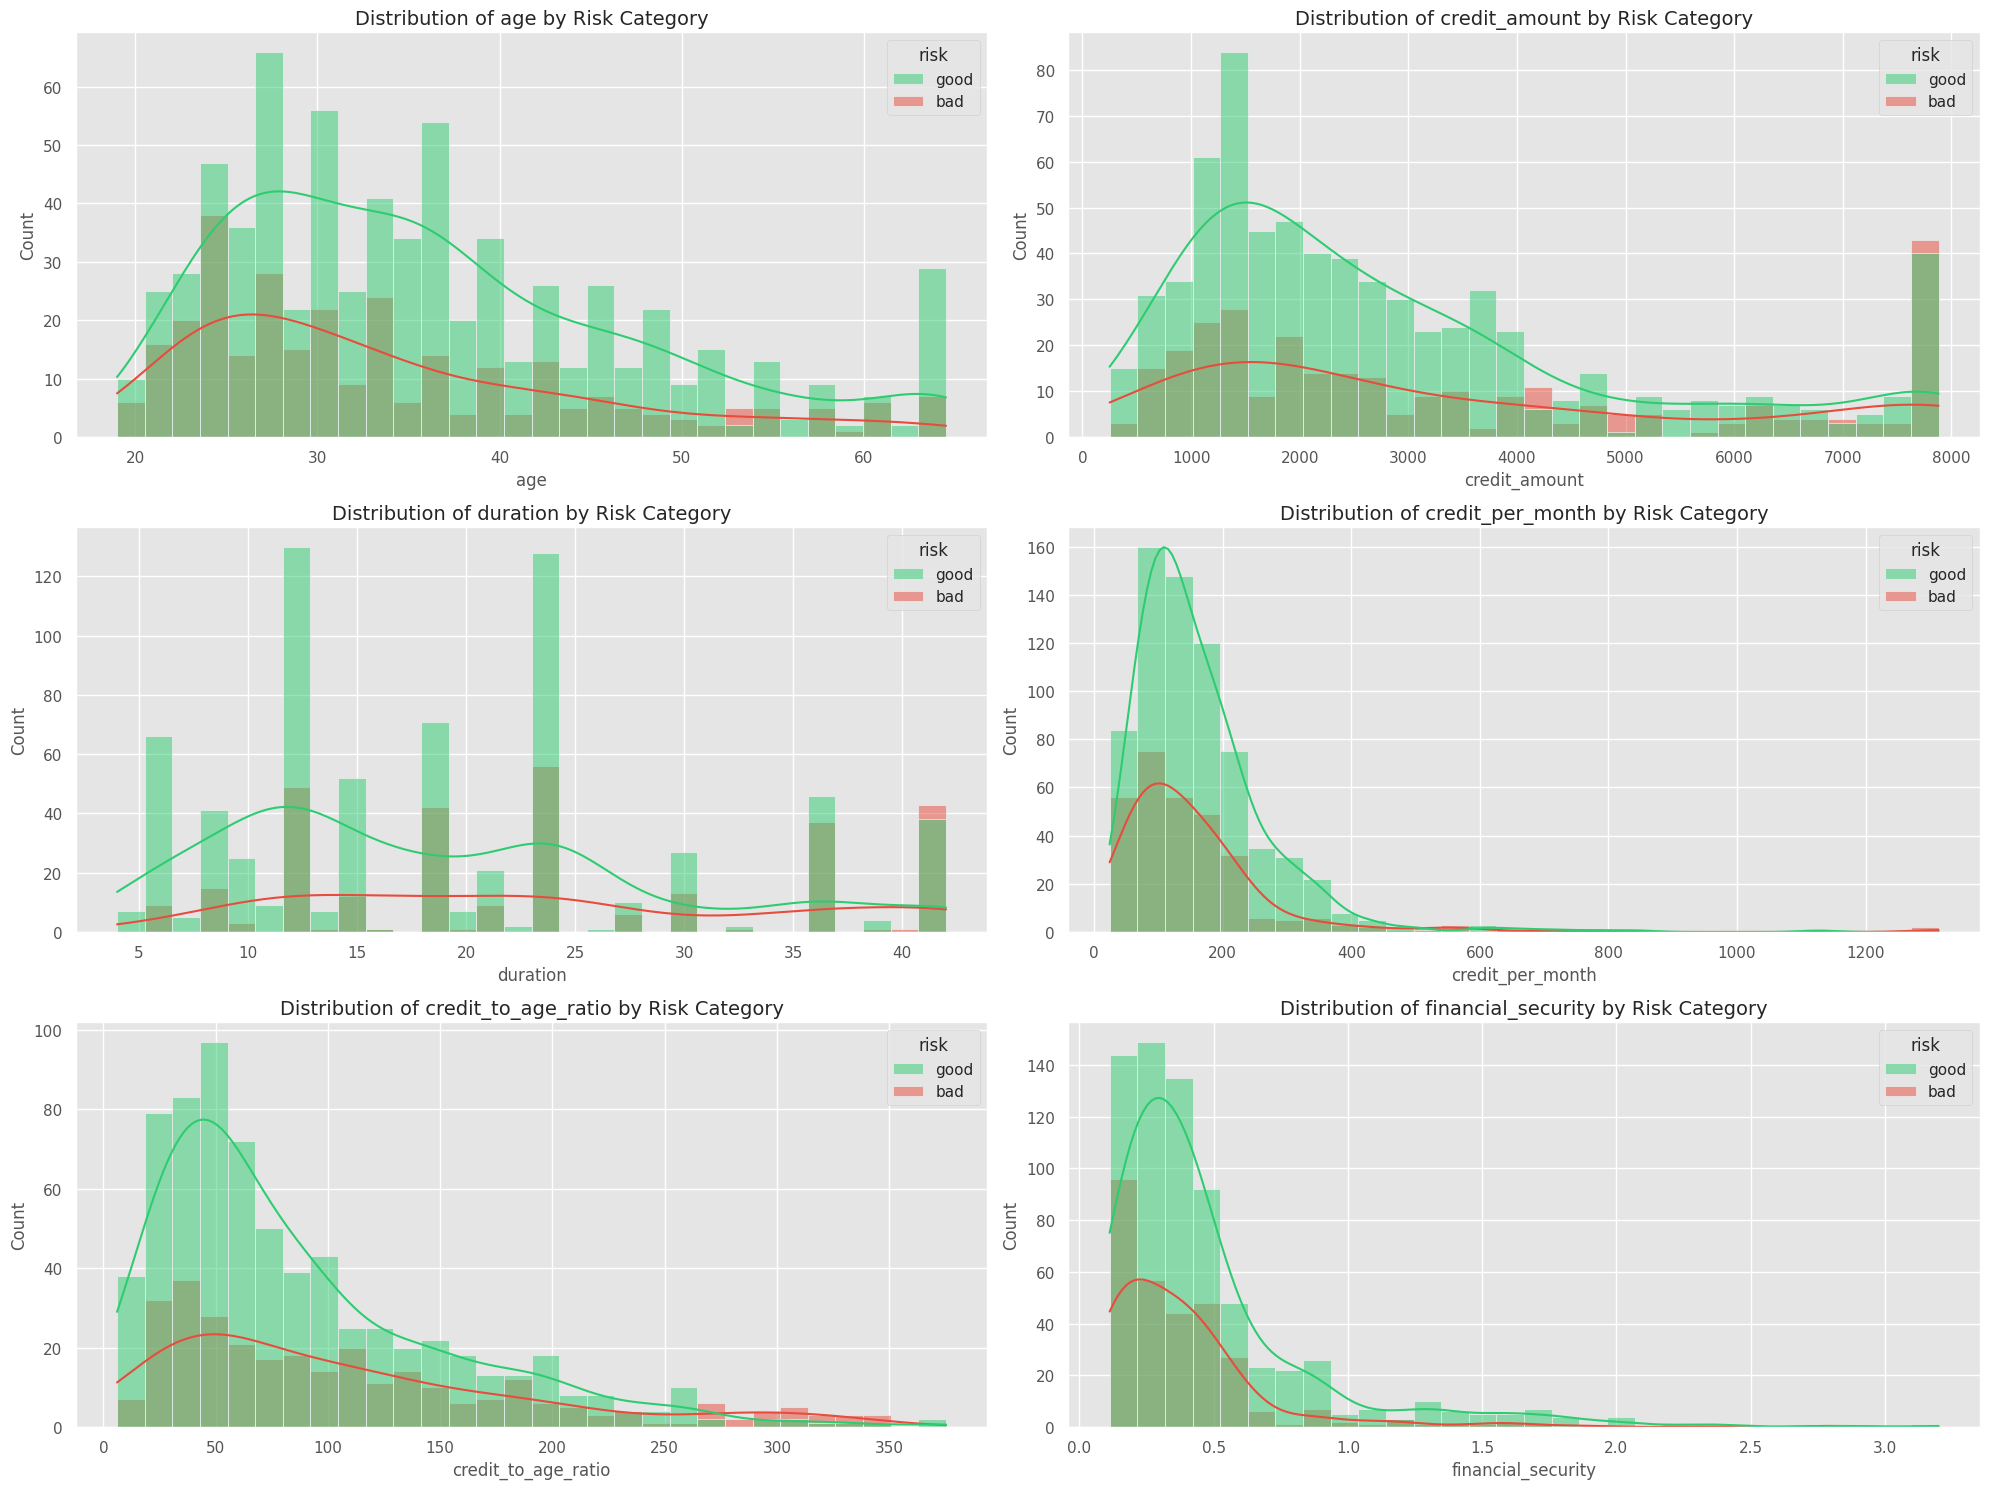

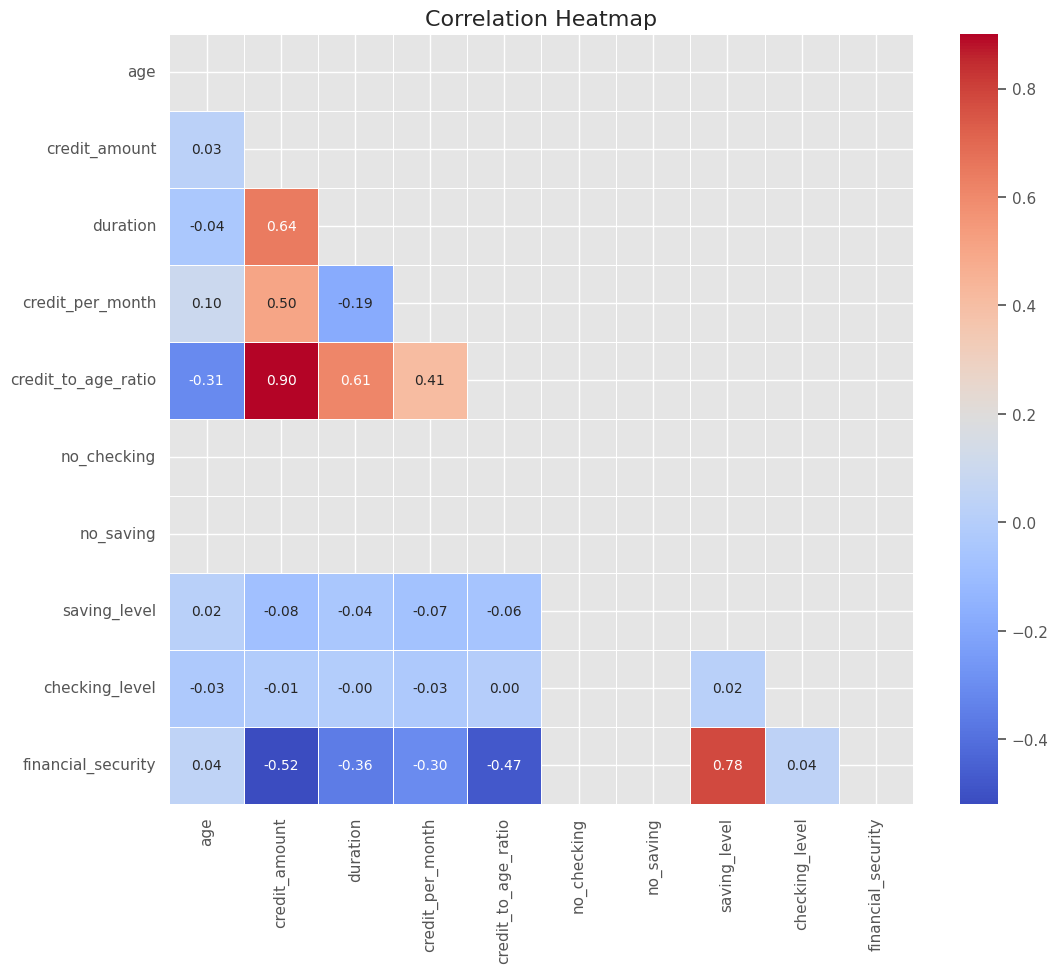

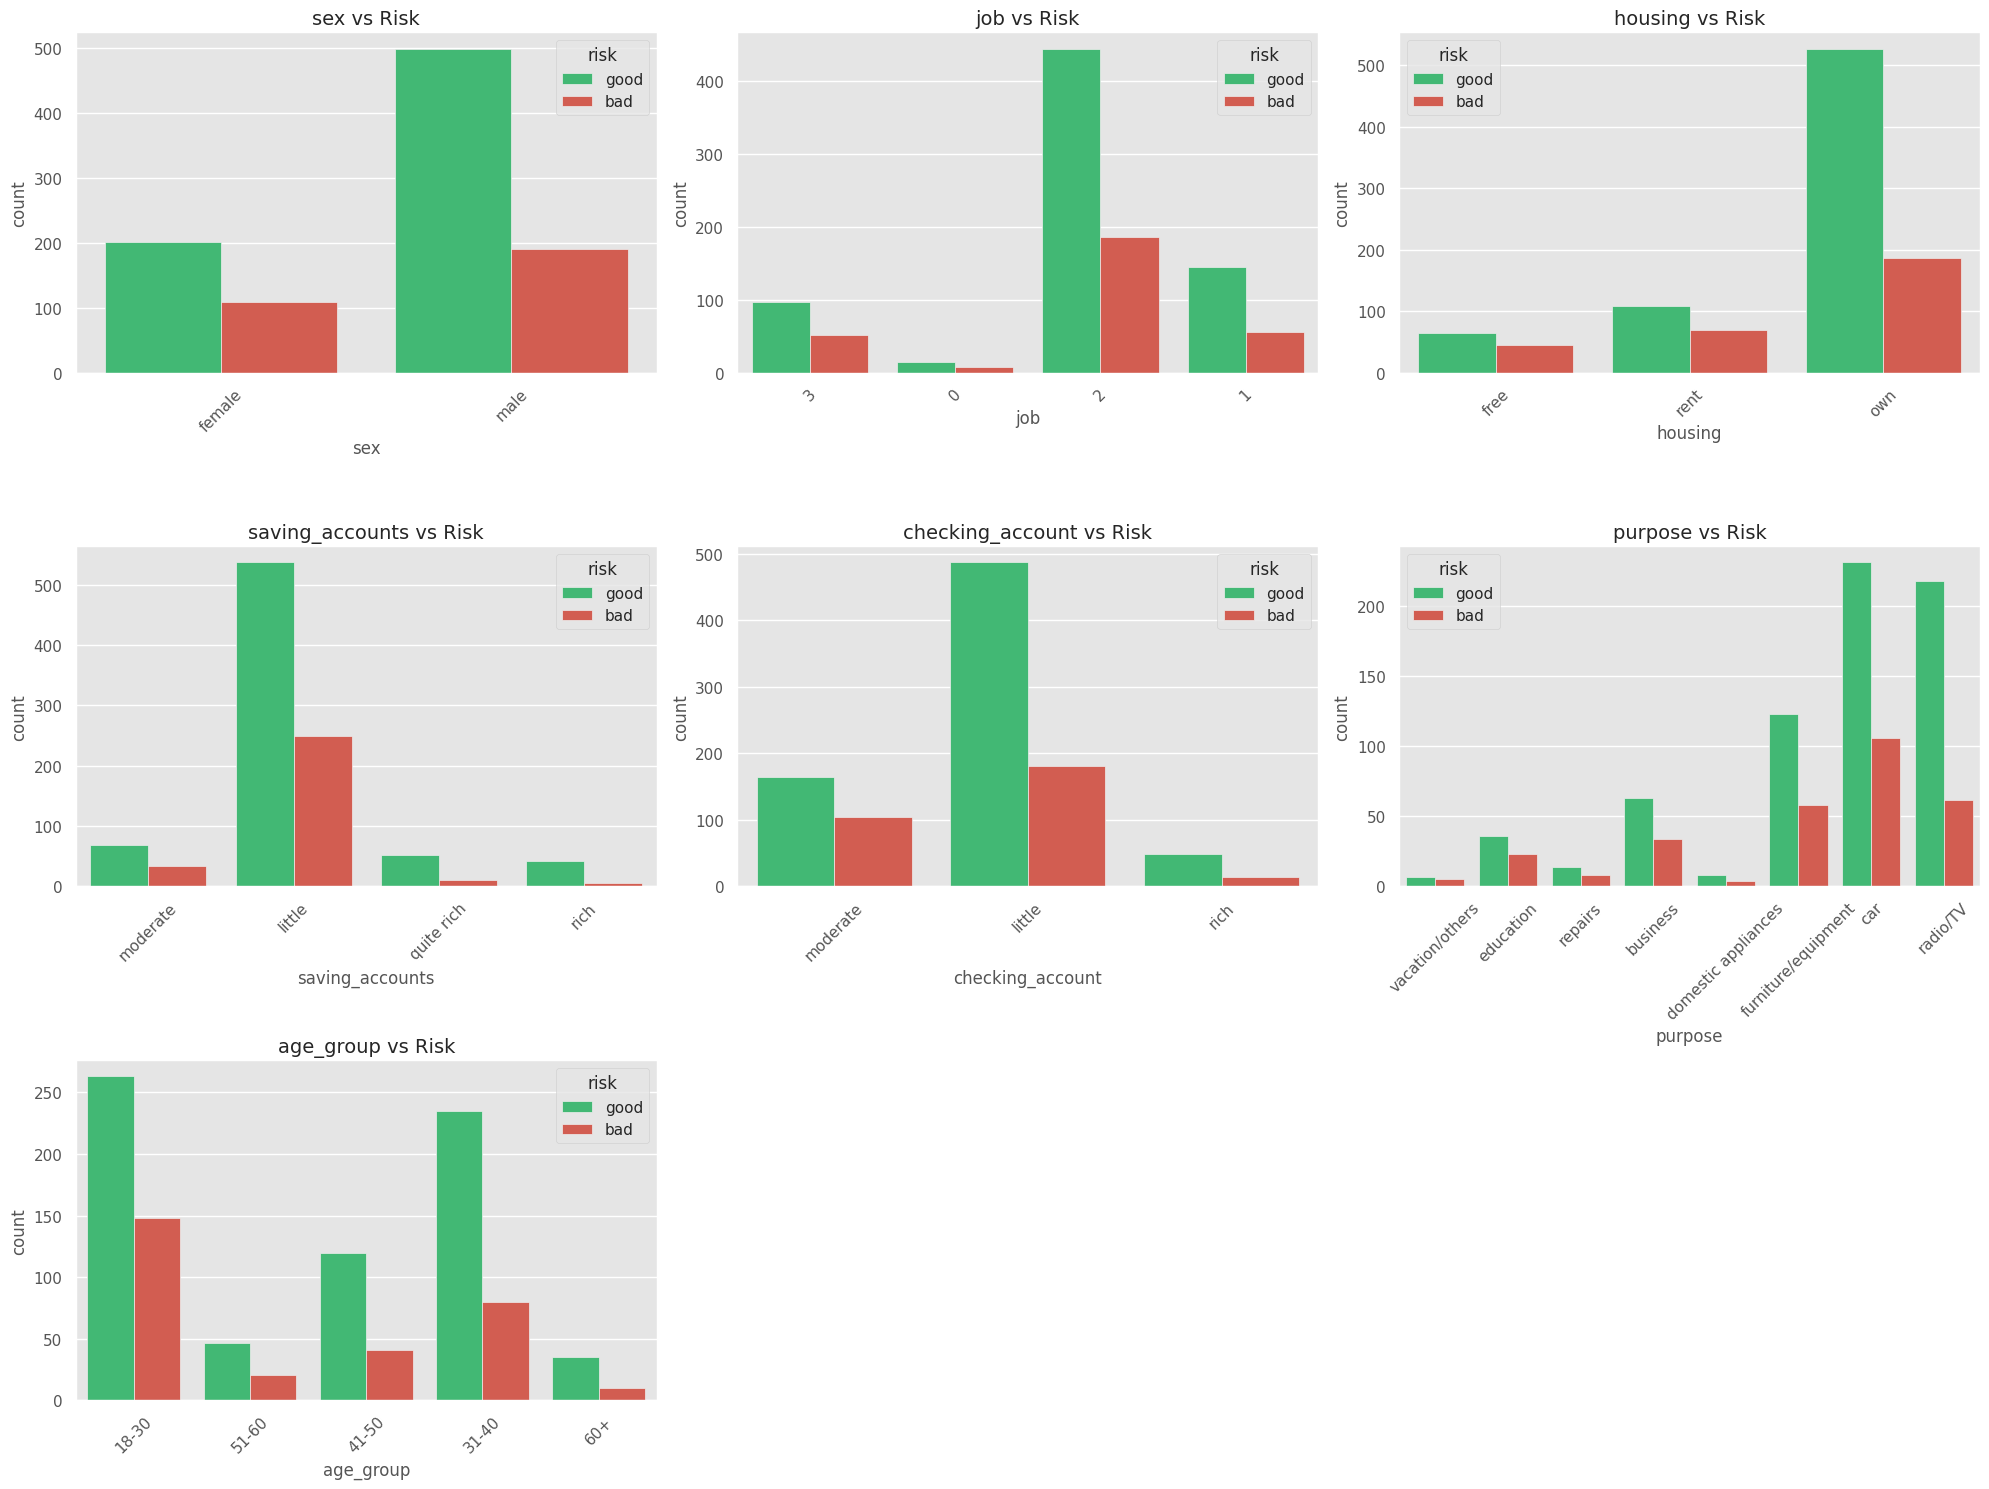

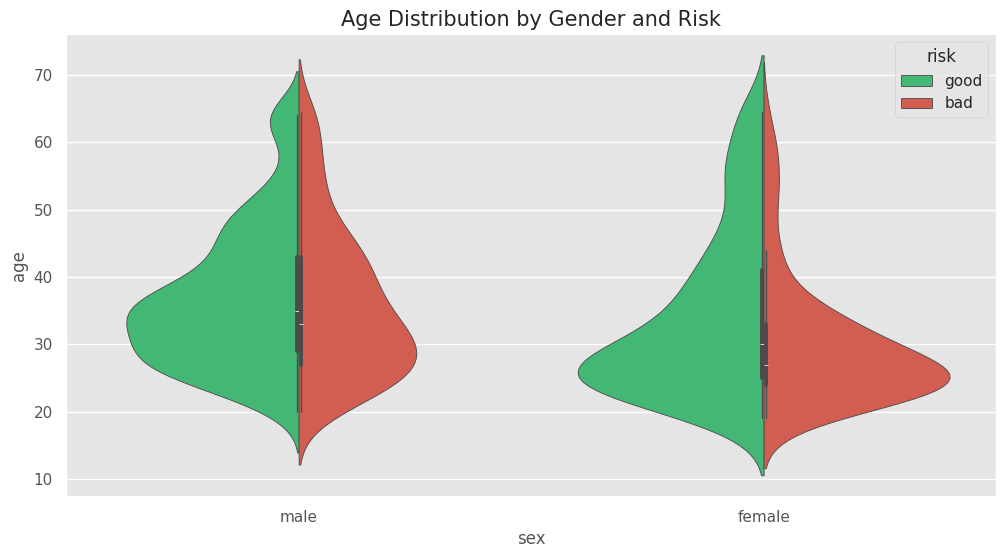

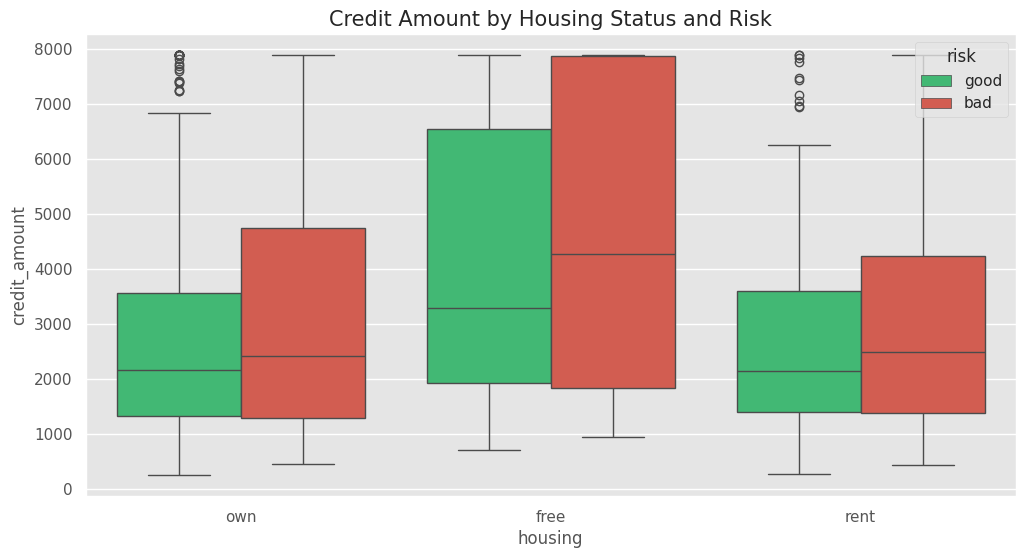

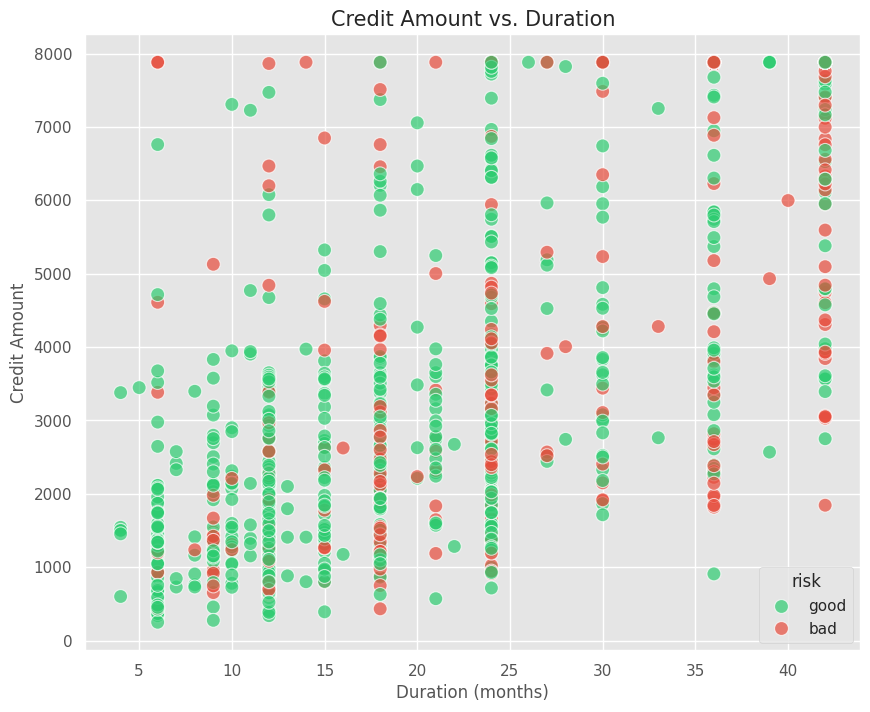

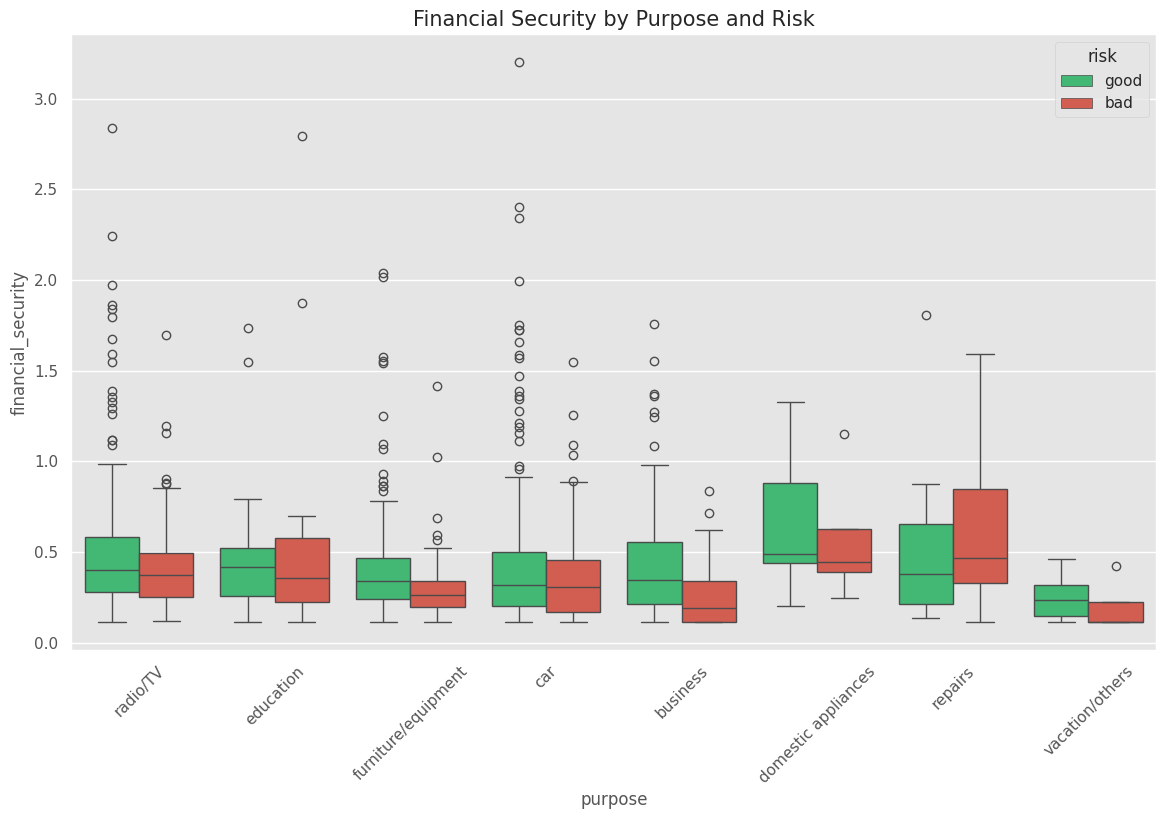

EDA completed. Visualizations saved to plots directory.


In [ ]:
# Define a custom color palette for visualizations
color_palette = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
sns.set_style('whitegrid')
sns.set_palette(color_palette)
#plt.style.use('seaborn-whitegrid')
plt.style.use('ggplot')


# Create a function for saving visualizations
def save_fig(fig, filename):
    fig.savefig(os.path.join(base_path, 'plots', f'{filename}.png'), dpi=300, bbox_inches='tight')
    print(f"Figure saved as {filename}.png")

# 1. Distribution of numerical features by risk category
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df, x=col, hue='risk', bins=30, kde=True, palette=['#2ECC71', '#E74C3C'])
    plt.title(f'Distribution of {col} by Risk Category', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
plt.tight_layout()
save_fig(plt, 'numerical_distributions')
plt.show()

# 2. Interactive visualization of numerical features
for col in num_cols:
    fig = px.histogram(df, x=col, color='risk', marginal='box',
                      title=f'Distribution of {col}',
                      color_discrete_map={'good': '#2ECC71', 'bad': '#E74C3C'})
    fig.update_layout(height=500, width=800)
    fig.show()
    fig.write_html(os.path.join(base_path, 'plots', f'{col}_distribution.html'))
# 3. Correlation heatmap
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
save_fig(plt, 'correlation_heatmap')
plt.show()

# 4. Interactive correlation heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.columns,
    colorscale='Viridis',
    zmin=-1, zmax=1
))
fig.update_layout(title='Interactive Correlation Heatmap', height=800, width=800)
fig.show()
fig.write_html(os.path.join(base_path, 'plots', f'{col}interactive_correlation.html'))

# 5. Categorical feature analysis
plt.figure(figsize=(20, 15))
for i, col in enumerate(cat_cols):
    plt.subplot(3, 3, i+1)
    # Convert 'risk' to numerical values before calculating the mean
    df['risk_numeric'] = df['risk'].map({'good': 1, 'bad': 0})  # Creating a temporary numerical column
    order = df.groupby(col)['risk_numeric'].mean().sort_values().index  # Using the temporary column
    sns.countplot(x=col, hue='risk', data=df, palette=['#2ECC71', '#E74C3C'], order=order)
    plt.title(f'{col} vs Risk', fontsize=14)
    plt.xticks(rotation=45)
plt.tight_layout()
save_fig(plt, 'categorical_analysis')
plt.show()
#  drop the temporary column if needed
df.drop(columns=['risk_numeric'], inplace=True)

# 6. Age distribution by gender and risk
plt.figure(figsize=(12, 6))
sns.violinplot(x='sex', y='age', hue='risk', data=df, palette=['#2ECC71', '#E74C3C'], split=True)
plt.title('Age Distribution by Gender and Risk', fontsize=15)
save_fig(plt, 'age_gender_risk')
plt.show()

# 7. Credit amount by housing status and risk
plt.figure(figsize=(12, 6))
sns.boxplot(x='housing', y='credit_amount', hue='risk', data=df, palette=['#2ECC71', '#E74C3C'])
plt.title('Credit Amount by Housing Status and Risk', fontsize=15)
save_fig(plt, 'credit_housing_risk')
plt.show()

# 8. Credit amount vs. duration with risk color coding
plt.figure(figsize=(10, 8))
sns.scatterplot(x='duration', y='credit_amount', hue='risk', data=df, palette=['#2ECC71', '#E74C3C'], s=100, alpha=0.7)
plt.title('Credit Amount vs. Duration', fontsize=15)
plt.xlabel('Duration (months)', fontsize=12)
plt.ylabel('Credit Amount', fontsize=12)
save_fig(plt, 'credit_duration_scatter')
plt.show()

# 9. Interactive 3D scatter plot
fig = px.scatter_3d(df, x='credit_amount', y='duration', z='age',
                   color='risk', symbol='sex',
                   color_discrete_map={'good': '#2ECC71', 'bad': '#E74C3C'})
fig.update_layout(title='3D Scatter Plot: Credit Amount, Duration, and Age', height=800)
fig.show()
fig.write_html(os.path.join(base_path, 'plots', '3d_scatter_plot.html'))

# 10. Financial security by purpose and risk
plt.figure(figsize=(14, 8))
sns.boxplot(x='purpose', y='financial_security', hue='risk', data=df, palette=['#2ECC71', '#E74C3C'])
plt.title('Financial Security by Purpose and Risk', fontsize=15)
plt.xticks(rotation=45)
save_fig(plt, 'financial_security_purpose')
plt.show()

# 11. Advanced visualization: Parallel Coordinates Plot
from plotly.express import parallel_coordinates

# Select subset of columns for parallel plot
parallel_cols = ['age', 'credit_amount', 'duration', 'credit_per_month', 'financial_security', 'risk']
fig = parallel_coordinates(df[parallel_cols], color_continuous_scale=px.colors.diverging.Tealrose,
                         color="credit_amount", labels={"risk": "Risk Category"})
fig.update_layout(title='Parallel Coordinates Plot', height=600)
fig.show()
fig.write_html(os.path.join(base_path, 'plots', 'parallel_coordinates_plot.html'))

print("EDA completed. Visualizations saved to plots directory.")

In [ ]:
# Import necessary libraries for data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import joblib

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['risk'])  # 'good' -> 0, 'bad' -> 1
joblib.dump(le, os.path.join(base_path, 'models', 'label_encoder.joblib'))

print(f"Target mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Separate features and target
X = df.drop(columns=['risk'])

# Separate numerical and categorical columns for preprocessing
cat_cols_final = [col for col in cat_cols if col in X.columns]
num_cols_final = [col for col in num_cols if col in X.columns]

# Create preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols_final),
        ('cat', categorical_transformer, cat_cols_final)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Original dataset shape:", X_train.shape, X_test.shape)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
ohe_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols_final)
feature_names = num_cols_final + list(ohe_cols)

print("Processed dataset shape:", X_train_processed.shape, X_test_processed.shape)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("After SMOTE resampling:", X_train_smote.shape)
print("Class distribution after SMOTE:", np.bincount(y_train_smote))

# Save the preprocessor
joblib.dump(preprocessor, os.path.join(base_path, 'models', 'preprocessor.joblib'))
print("Preprocessor saved.")

# Reshape data for CNN input
# CNN expects input shape (samples, timesteps, features)
X_train_cnn = X_train_smote.reshape(X_train_smote.shape[0], 1, X_train_smote.shape[1])
X_test_cnn = X_test_processed.reshape(X_test_processed.shape[0], 1, X_test_processed.shape[1])

print("CNN input shapes:", X_train_cnn.shape, X_test_cnn.shape)

Target mapping: {'bad': np.int64(0), 'good': np.int64(1)}
Original dataset shape: (800, 17) (200, 17)
Processed dataset shape: (800, 35) (200, 35)
After SMOTE resampling: (1120, 35)
Class distribution after SMOTE: [560 560]
Preprocessor saved.
CNN input shapes: (1120, 1, 35) (200, 1, 35)



--- Logistic Regression Results ---
Accuracy: 0.6600
Precision: 0.8103
Recall: 0.6714
F1 Score: 0.7344
ROC AUC: 0.6800


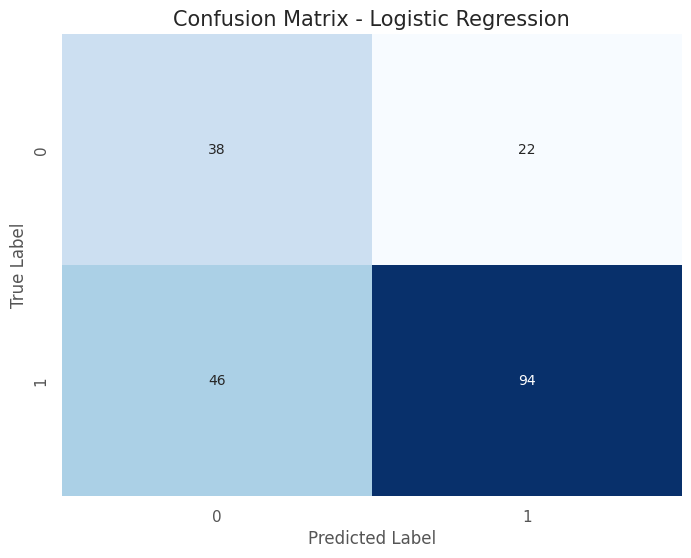

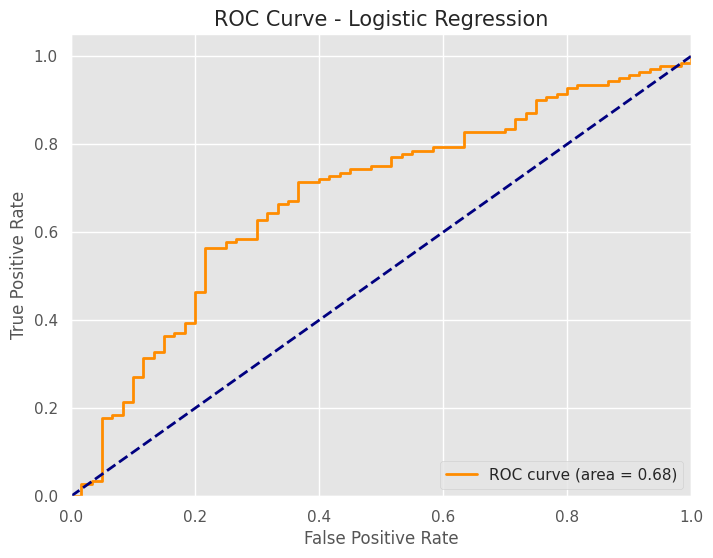


--- Random Forest Results ---
Accuracy: 0.7100
Precision: 0.7697
Recall: 0.8357
F1 Score: 0.8014
ROC AUC: 0.6624


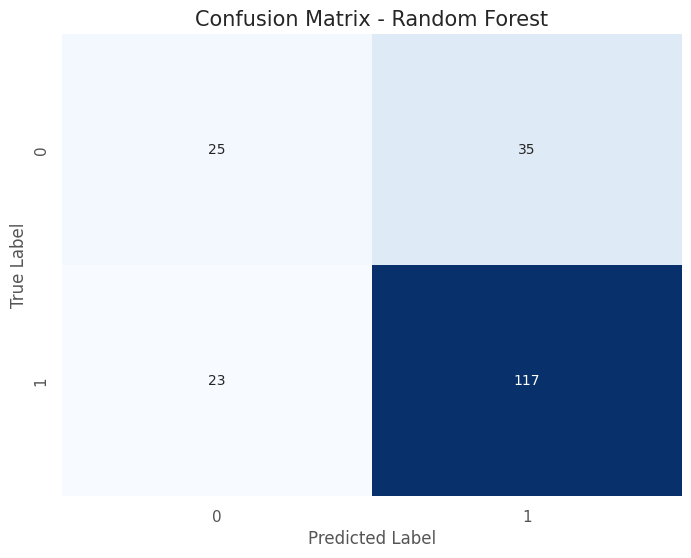

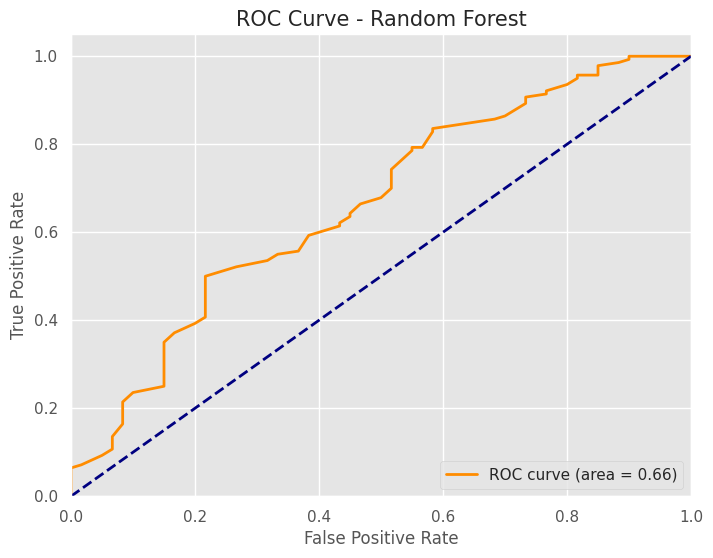


--- Gradient Boosting Results ---
Accuracy: 0.6300
Precision: 0.7292
Recall: 0.7500
F1 Score: 0.7394
ROC AUC: 0.6249


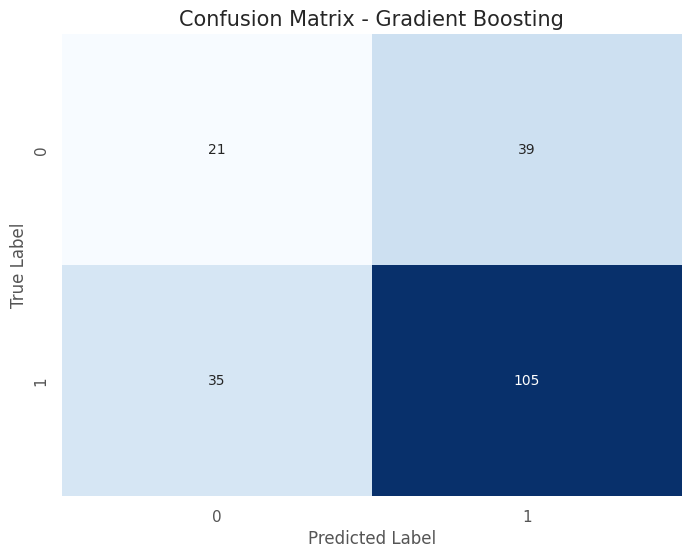

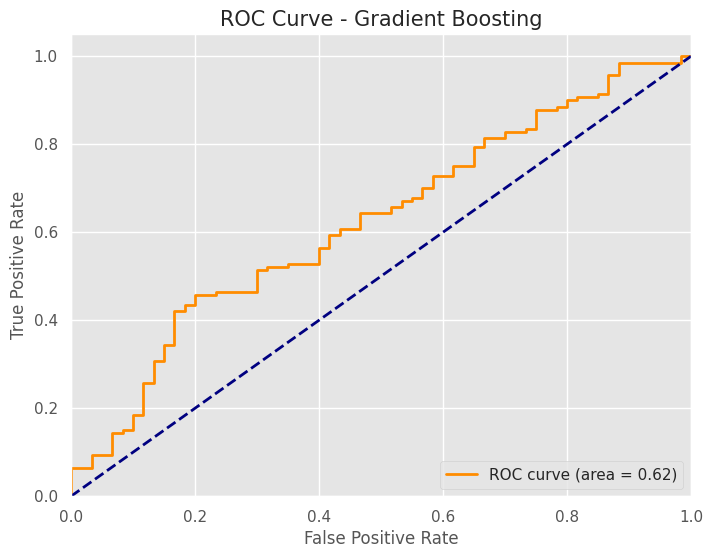


--- Support Vector Machine Results ---
Accuracy: 0.6600
Precision: 0.7769
Recall: 0.7214
F1 Score: 0.7481
ROC AUC: 0.6711


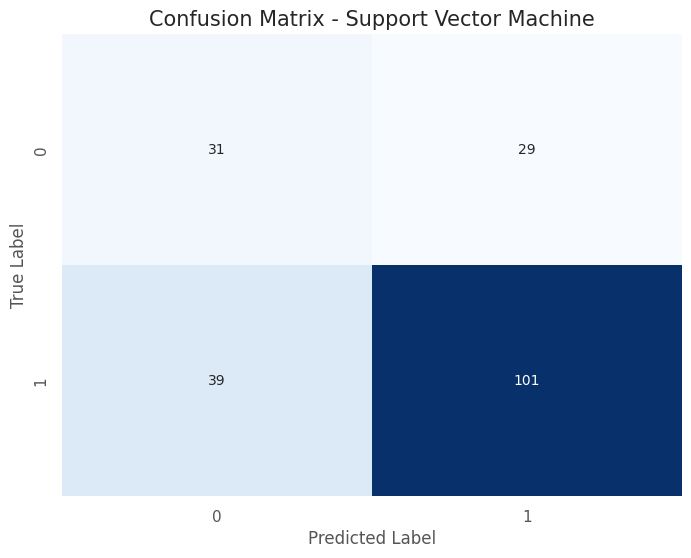

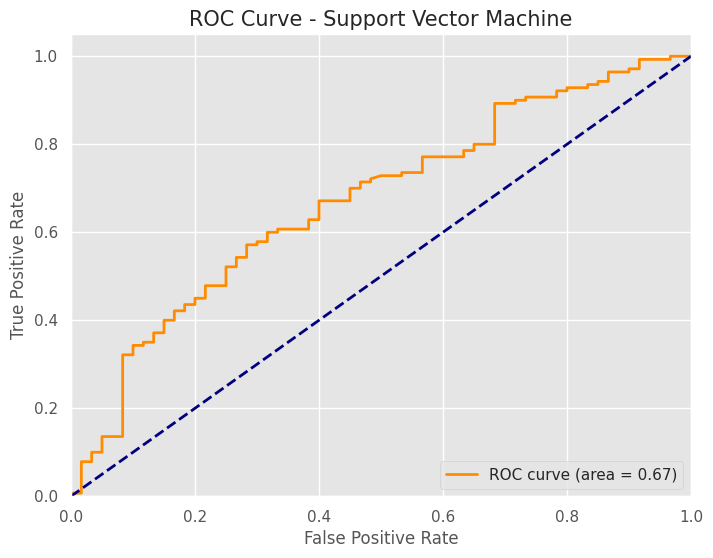


--- Decision Tree Results ---
Accuracy: 0.6150
Precision: 0.7333
Recall: 0.7071
F1 Score: 0.7200
ROC AUC: 0.5536


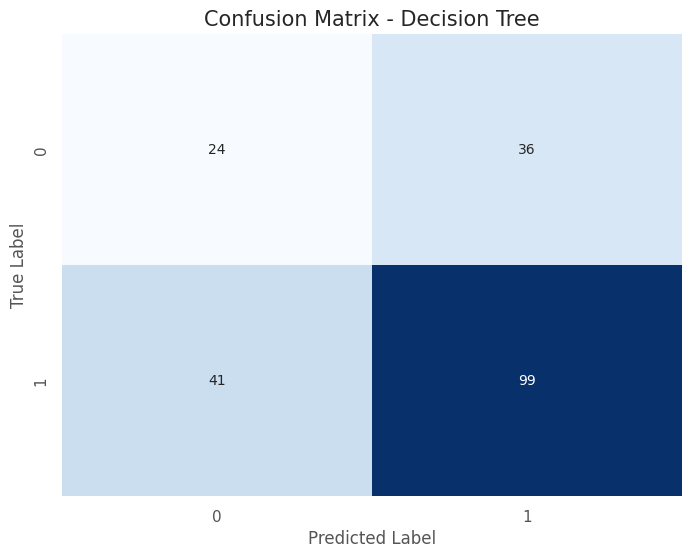

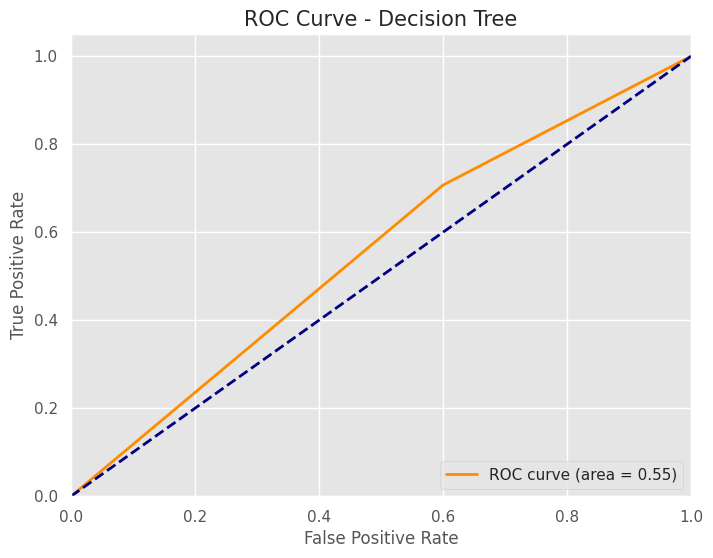

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.660,0.810345,0.671429,0.734375,0.680000
1,Random Forest,0.710,0.769737,0.835714,0.801370,0.662440
2,Gradient Boosting,0.630,0.729167,0.750000,0.739437,0.624881
3,Support Vector Machine,0.660,0.776923,0.721429,0.748148,0.671131
4,Decision Tree,0.615,0.733333,0.707143,0.720000,0.553571


Baseline model evaluation completed.

Performing hyperparameter tuning for Random Forest...
Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.7982

--- Tuned Random Forest Results ---
Accuracy: 0.7050
Precision: 0.7647
Recall: 0.8357
F1 Score: 0.7986
ROC AUC: 0.6710


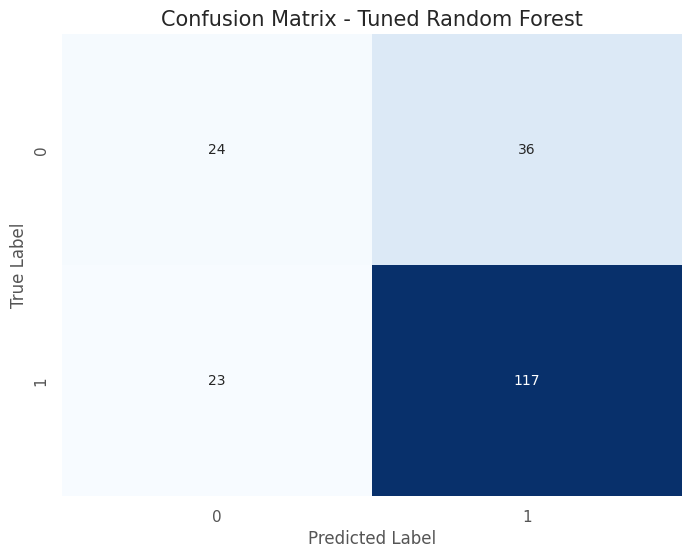

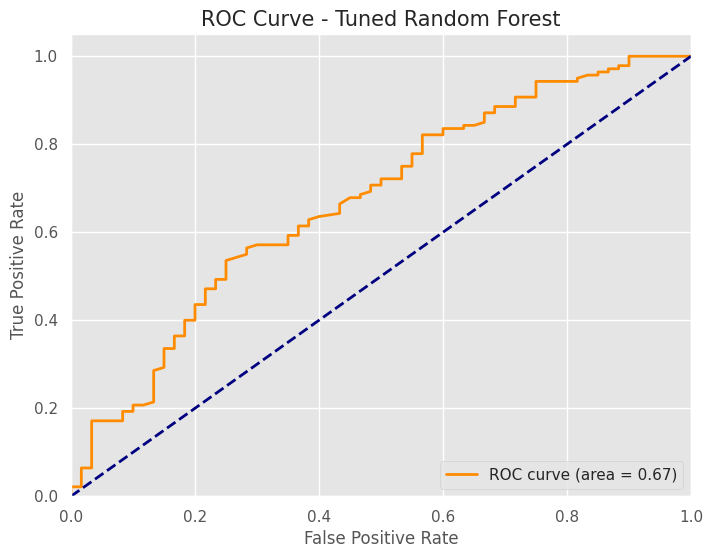

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.660,0.810345,0.671429,0.734375,0.680000
1,Random Forest,0.710,0.769737,0.835714,0.801370,0.662440
2,Gradient Boosting,0.630,0.729167,0.750000,0.739437,0.624881
3,Support Vector Machine,0.660,0.776923,0.721429,0.748148,0.671131
4,Decision Tree,0.615,0.733333,0.707143,0.720000,0.553571
5,Tuned Random Forest,0.705,0.764706,0.835714,0.798635,0.671012


Hyperparameter tuning completed.


In [ ]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score

# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.savefig(os.path.join(base_path, 'plots', f"{model_name.lower().replace(' ', '_')}_cm.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {model_name}', fontsize=15)
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(base_path, 'plots', f"{model_name.lower().replace(' ', '_')}_roc.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Save model
    joblib.dump(model, os.path.join(base_path, 'models', f"{model_name.lower().replace(' ', '_')}.joblib"))

    # Return metrics for comparison
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

# Create and evaluate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_smote, X_test_processed, y_train_smote, y_test, name)
    results.append(result)

# Create a dataframe with results
results_df = pd.DataFrame(results)
display(results_df)

# Save results
results_df.to_csv(os.path.join(base_path, 'models', 'all_model_comparison.csv'), index=False)
print("Baseline model evaluation completed.")

# Hyperparameter tuning for the best baseline model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax()]['Model']
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }
    model = RandomForestClassifier(random_state=42)

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
    model = GradientBoostingClassifier(random_state=42)

elif best_model_name == 'Support Vector Machine':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }
    model = SVC(probability=True, random_state=42)

elif best_model_name == 'Decision Tree':
    param_grid = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    model = DecisionTreeClassifier(random_state=42)

else:  # Logistic Regression
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    model = LogisticRegression(max_iter=2000, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
best_model = grid_search.best_estimator_
tuned_result = evaluate_model(best_model, X_train_smote, X_test_processed, y_train_smote, y_test, f"Tuned {best_model_name}")

# Update results
results.append(tuned_result)
results_df = pd.DataFrame(results)
display(results_df)

# Save updated results
results_df.to_csv(os.path.join(base_path, 'models', 'all_model_comparison_tuned.csv'), index=False)
print("Hyperparameter tuning completed.")

In [ ]:
# Import necessary libraries for deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)


# Function to create a CNN feature extractor
def create_cnn_feature_extractor(input_shape):
    """
    Creates a CNN model for feature extraction.

    Args:
        input_shape (tuple): Shape of the input data.

    Returns:
        keras.Model: CNN feature extractor model.
    """
    model = Sequential(name="cnn_feature_extractor")  # Give the model a name

    # First convolutional block
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                      input_shape=input_shape, padding='same', name="conv1d_1"))  # Padding='same' to handle small input size
    model.add(MaxPooling1D(pool_size=2, name="maxpooling1d_1"))

    # Second convolutional block
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name="conv1d_2"))
    model.add(MaxPooling1D(pool_size=2, name="maxpooling1d_2"))



    # Flatten layer
    model.add(Flatten(name="flatten_1"))

    # Dense layer for feature representation
    model.add(Dense(100, activation='relu', name="dense_1"))
    model.add(Dropout(0.5, name="dropout_1")) # Dropout for regularization

    return model

# Function to evaluate CNN-ML hybrid models
def evaluate_hybrid_model(X_train_cnn, y_train, X_test_cnn, y_test, ml_model, model_name, base_path):
    """
    Evaluates a CNN-ML hybrid model.

    Args:
        X_train_cnn (np.ndarray): Training data for CNN.
        y_train (np.ndarray): Training labels.
        X_test_cnn (np.ndarray): Test data for CNN.
        y_test (np.ndarray): Test labels.
        ml_model (object): Scikit-learn machine learning model.
        model_name (str): Name of the model.
        base_path (str): Base path for saving results.
    """

    input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
    cnn_model = create_cnn_feature_extractor(input_shape)

    # Add a mock output layer to train the CNN feature extractor
    x = cnn_model.output
    output = Dense(1, activation='sigmoid', name="output_layer")(x)
    full_model = Model(inputs=cnn_model.input, outputs=output, name=model_name)

    # Compile the full model
    full_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    # Train the CNN feature extractor with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    full_model.fit(
        X_train_cnn, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Remove the output layer to get feature extractor
    feature_model = Model(inputs=full_model.input, outputs=full_model.layers[-2].output)

    # Get CNN features for training and test data
    X_train_features = feature_model.predict(X_train_cnn)
    X_test_features = feature_model.predict(X_test_cnn)

    # Train the ML model on CNN features
    ml_model.fit(X_train_features, y_train)

    # Make predictions and evaluate
    y_pred = ml_model.predict(X_test_features)
    y_pred_proba = ml_model.predict_proba(X_test_features)[:, 1]

    # Calculate and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Generate and save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.savefig(
    os.path.join(
        base_path, 
        'plots', 
        f"{model_name.lower().replace(' ', '_').replace('-', '_')}_cm.png"
    ), 
    dpi=300, 
    bbox_inches='tight'
)
    plt.show()

    # Generate and save ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {model_name}', fontsize=15)
    plt.legend(loc='lower right')
    plt.savefig(
        os.path.join(
            base_path, 
            'plots', 
            f"{model_name.lower().replace(' ', '_').replace('-', '_')}_roc.png"
        ), 
        dpi=300, 
        bbox_inches='tight'
    )
    plt.show()

feature_model.save(
    os.path.join(
        base_path,
        'models',
        f"{model_name.lower().replace(' ', '_').replace('-', '_')}_cnn.h5"
    )
)

joblib.dump(
    ml_model,
    os.path.join(
        base_path,
        'models',
        f"{model_name.lower().replace(' ', '_').replace('-', '_')}_ml.joblib"
    )
)

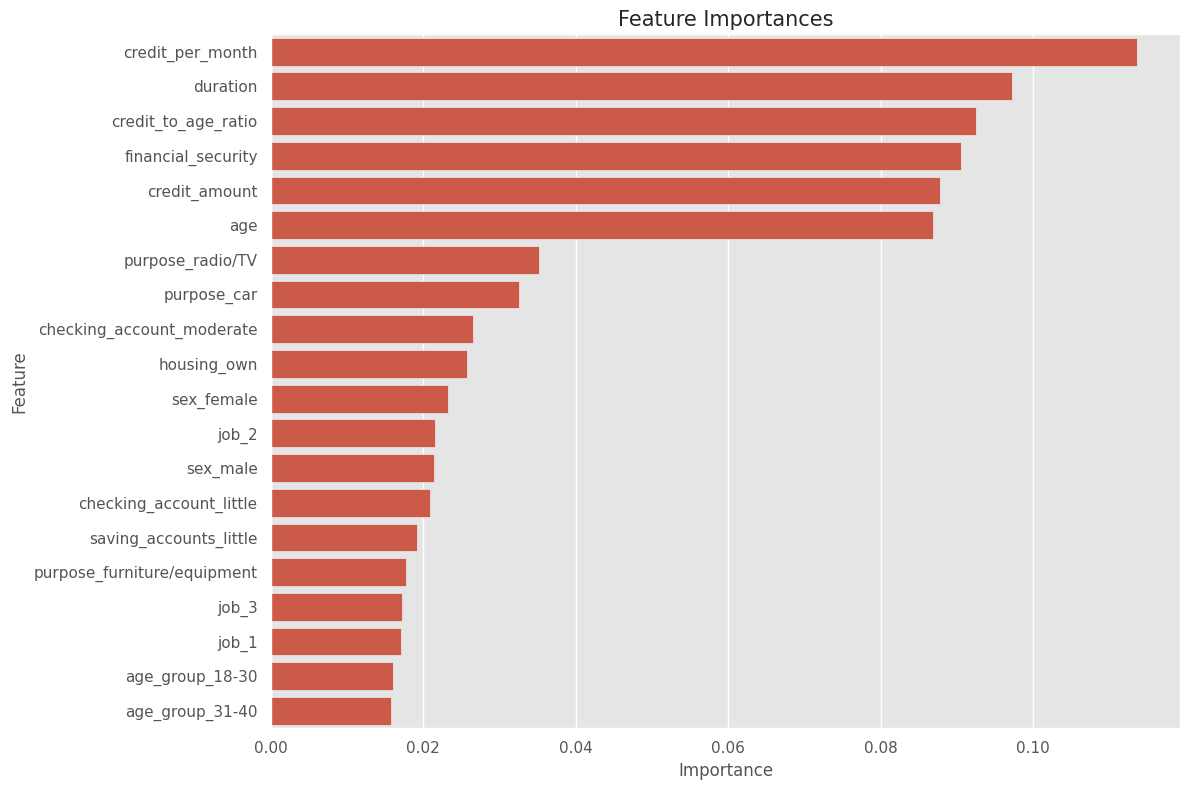


Generating SHAP values for model interpretation...


<Figure size 1200x1000 with 0 Axes>

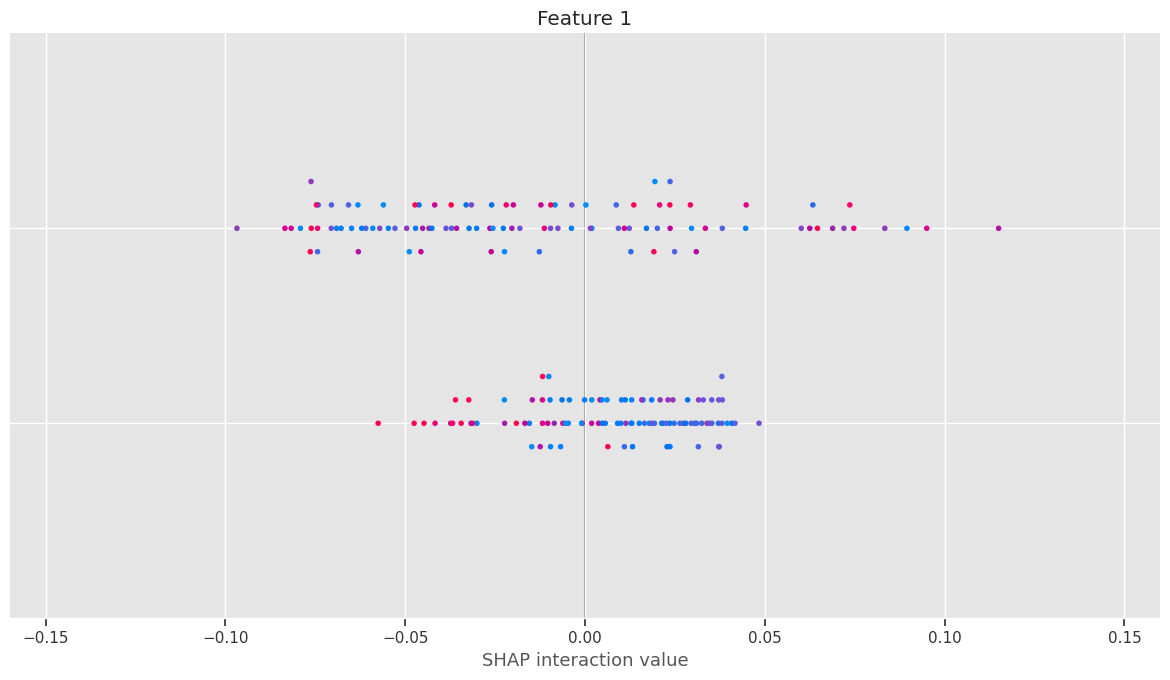

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

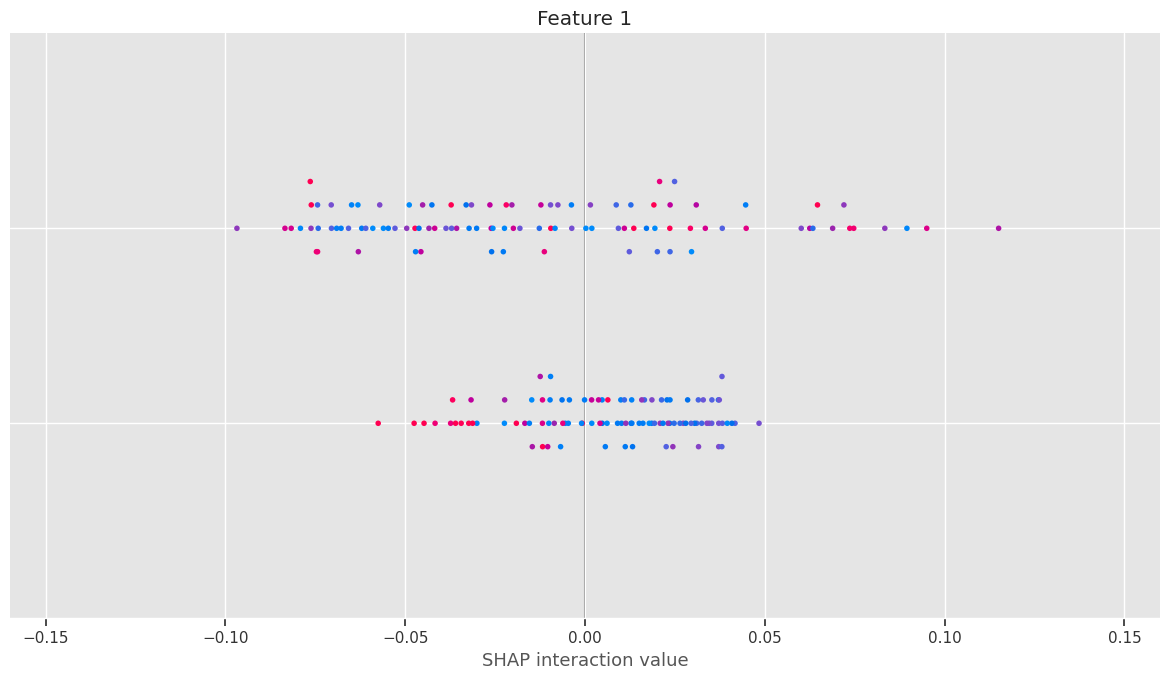

<Figure size 640x480 with 0 Axes>

In [ ]:
# Model interpretation for the best model
if 'CNN' in best_model_name:
    print("\nPerforming model interpretation for the hybrid model...")

    # If best model is a hybrid model, we need to load it
    if 'CNN-RF' in best_model_name:
        ml_model = joblib.load(f'{base_path}/models/cnn_rf_ml.joblib')

        # Feature importance for Random Forest
        feature_imp = pd.DataFrame(sorted(zip(ml_model.feature_importances_,
                                             range(X_train_features.shape[1]))),
                                 columns=['Value', 'Feature'])

        plt.figure(figsize=(12, 8))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
        plt.title(f'Feature Importances from CNN-extracted Features', fontsize=15)
        plt.tight_layout()
        plt.savefig(
    os.path.join(
        base_path,
        'plots',
        'cnn_rf_feature_importance.png'
    ),
    dpi=300,
    bbox_inches='tight'
)
        plt.show()

    elif 'CNN-GB' in best_model_name:
        ml_model = joblib.load(f'{base_path}/models/cnn_gb_ml.joblib')

        # Feature importance for Gradient Boosting
        feature_imp = pd.DataFrame(sorted(zip(ml_model.feature_importances_,
                                             range(X_train_features.shape[1]))),
                                 columns=['Value', 'Feature'])

        plt.figure(figsize=(12, 8))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
        plt.title(f'Feature Importances from CNN-extracted Features', fontsize=15)
        plt.tight_layout()
        plt.savefig(
    os.path.join(
        base_path,
        'plots',
        'cnn_gb_feature_importance.png'
    ),
    dpi=300,
    bbox_inches='tight'
)
        plt.show()

    else:
        # For standalone CNN or other models, use a different approach
        print("For CNN models, direct feature importance is not available in the same way as tree-based models.")

else:
    # For traditional ML models
    if 'Random Forest' in best_model_name:
        # Load the best model
        model = joblib.load(f'{base_path}/models/random_forest.joblib')

        # Get feature importances
        importances = model.feature_importances_
        feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_imp = feature_imp.sort_values('Importance', ascending=False)

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title('Feature Importances', fontsize=15)
        plt.tight_layout()
        plt.savefig(
            os.path.join(
        base_path,
        'plots',
        'feature_importance.png' ),
    dpi=300,
    bbox_inches='tight'
)
        plt.show()

    elif 'Gradient Boosting' in best_model_name:
        # Load the best model
        model = joblib.load(f'{base_path}/models/gradient_boosting.joblib')

        # Get feature importances
        importances = model.feature_importances_
        feature_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feature_imp = feature_imp.sort_values('Importance', ascending=False)

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title('Feature Importances', fontsize=15)
        plt.tight_layout()
        plt.savefig(
            os.path.join(
        base_path,
        'plots',
        'feature_importance.png' ),
    dpi=300,    
    bbox_inches='tight'
)
        plt.show()

    elif 'Logistic Regression' in best_model_name:
        # Load the best model
        model = joblib.load(f'{base_path}/models/logistic_regression.joblib')

        # Get coefficients
        coef = model.coef_[0]
        feature_imp = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
        feature_imp['AbsCoef'] = feature_imp['Coefficient'].abs()
        feature_imp = feature_imp.sort_values('AbsCoef', ascending=False)

        # Plot coefficients
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Coefficient', y='Feature', data=feature_imp.head(20))
        plt.title('Logistic Regression Coefficients', fontsize=15)
        plt.tight_layout()
        plt.savefig(
            os.path.join(
        base_path,
        'plots',
        'logistic_regression_coefficients.png' ),   
    dpi=300,
    bbox_inches='tight'
)
        plt.show()

    else:
        print("Feature importance not available for this model type.")

# Generate SHAP values for model interpretation (for ML models)
if not 'CNN' in best_model_name or 'CNN-' in best_model_name:
    try:
        import shap

        print("\nGenerating SHAP values for model interpretation...")

        # Load the appropriate model and data
        if 'CNN-' in best_model_name:
            if 'CNN-RF' in best_model_name:
                model = joblib.load(f'{base_path}/models/cnn_rf_ml.joblib')
            elif 'CNN-GB' in best_model_name:
                model = joblib.load(f'{base_path}/models/cnn_gb_ml.joblib')
            elif 'CNN-LR' in best_model_name:
                model = joblib.load(f'{base_path}/models/cnn_lr_ml.joblib')

            # Load CNN feature extractor
            feature_model = tf.keras.models.load_model(f'{base_path}/models/{best_model_name.lower().replace(" ", "_").replace("-", "_")}_cnn.h5')

            # Generate features
            X_shap = feature_model.predict(X_test_cnn[:100])  # Sample for speed
        else:
            if 'Random Forest' in best_model_name:
                model = joblib.load(f'{base_path}/models/random_forest.joblib')
            elif 'Gradient Boosting' in best_model_name:
                model = joblib.load(f'{base_path}/models/gradient_boosting.joblib')
            elif 'Logistic Regression' in best_model_name:
                model = joblib.load(f'{base_path}/models/logistic_regression.joblib')

            X_shap = X_test_processed[:100]  # Sample for speed

        # Initialize SHAP explainer
        if 'Random Forest' in best_model_name or 'CNN-RF' in best_model_name:
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.KernelExplainer(model.predict_proba, X_shap)

        # Calculate SHAP values
        shap_values = explainer.shap_values(X_shap)

        # Summary plot
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values,
                         X_shap, plot_type="bar")
        plt.savefig(
            
    os.path.join(
        base_path,  
        
        'plots',
        'shap_summary.png'
    ),
    dpi=300,        
    
    bbox_inches='tight'
)
        plt.title('SHAP Summary Plot', fontsize=15)
        plt.show()

        # Detailed plot for top 10 features
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values[1] if isinstance(shap_values, list) else shap_values,
                         X_shap)
        plt.savefig(
    os.path.join(
        base_path,
        'plots',
        'shap_summary_detailed.png'
    ),dpi=300,
    bbox_inches='tight'
)    
        plt.show()

    except Exception as e:
        print(f"Error generating SHAP values: {e}")
        print("Skipping SHAP analysis.")


